## Introduction to Mesa

For all agent-based models in this course, [Mesa](https://github.com/projectmesa/mesa) will be the primary framework to assist us with the implementation. The reason for using Mesa is its simplicity and flexibility, and python, as its language, offers many [object-oriented language features that are closely tied to agent-based modelling](http://www.agent-based-models.com/blog/2010/03/30/agent-based-modeling/).

If you are unsure what a framework is or what the difference between a framework and a library is, you may want to look at [this post](https://www.quora.com/Whats-the-difference-between-a-library-and-a-framework). Simply said, a framework acts like a skeleton that guides you to fill the code in and does the job for you without worrying too much about the underlying technical details.

There are several core base classes offered by Mesa that are relevant to our course:

- `Agent` are the actors in the model. Each agent should have a **unique_id** and a reference to the **model** it belongs to. Further attributes can be added, as you will see in the exercises.

- `Model` contains many useful methods that we can override. We will mostly use the methods `step()` and `run_model()`.

- `Time` lets you specify in what sequence agents should take their steps. Although you can already find many possibilities implemented by Mesa, we will use primarily `SimultaneousActivation`. With this schedule all agents will update their attributes **as if** they are made simultaneously. Precisely we store the updated values somewhere else and only once all agents have had the chance to interact with the previous state do we the environment and their state values.

- `Space` offers several classes that allow us to place agent.

- `DataCollector` collects data generated by a Mesa model. This class will help you to analyse the model.

- Some of the mentioned classes maintain references to each other. For example, `Time` can trigger an `Agent`'s methods to advance it one time step. The example ABM below shows how to set the references for `Model`, `Time`, and `Agent`.

The following illustration summarises the classes, and which ones maintain references among each other.

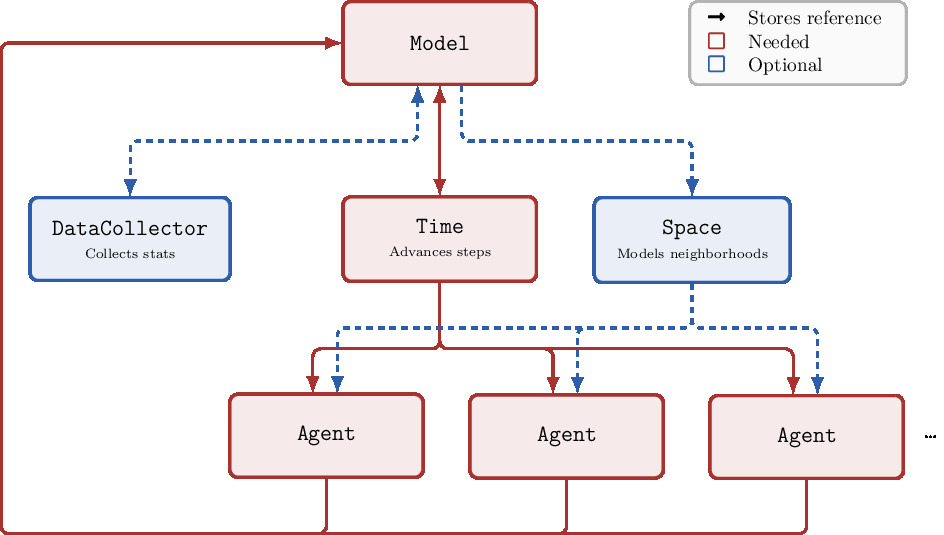

We strongly encourage you to look at the [source code](https://github.com/projectmesa/mesa/tree/main/mesa) whenever you get confused by Mesa's documentation. As you may find out later, most of the notions introduced by Mesa are intuitive. In addition, looking at a few [example models](https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html) can help you quickly see common patterns used by other model implementors.

# Example ABM

To exemplify how to use Mesa, we consider the following simple ABM (loosely based on Mesa's [official tutorial](https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html)):
- Each agent owns an amount of money, initially $1$ unit of money each.
- At each time step, all agents re-assign 1 unit of money (if they have it) to random agents.

What is the distribution of money after $K$ runs?

In [1]:
from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from random import choice
import matplotlib.pyplot as plt

We exemplify a simultaneous update (`SimultaneousActivation`). This means that in each step all agents redistribute their unit of money at the same time. `SimultaneousActivation` requires two methods of `Agent` (`step` and `advance`) whose usage we illustrate below.

In [2]:
# Class to model the agents

class MyAgent(Agent):
    def __init__(self, agent_id, model, initial_money):
        """Initialize an agent."""
        super().__init__(agent_id, model)  # This is important!
        # without this line, our agent "MyAgent" class is not a proper subclass of Agent and will not work.

        self.money = initial_money
        self._agent_to_redistribute = None
        # We use self._agent_to_redistribute to store the chosen agent to whom to redistribute the money unit.
        # Although there are no truly private variables in python, using a leading underscore makes
        # self._agent_to_redistribute ignored when doing "from module import *"

    def step(self):  # We are defining a new step function for our class MyAgent. What was the step function of the class Agent from Mesa doing?
        """Agent chooses a random agent to whom to redistribute money but does not execute yet."""
        if self.money > 0:
            all_agents = list(self.model.schedule.agents)
            all_agents.remove(self)  # avoid redistributing to itself
            self._agent_to_redistribute = choice(all_agents)
        else:
            self._agent_to_redistribute = None  # i.e. no redistribution

    def advance(self):
        """Agent redistributes money to the agent chosen by step()."""
        other_agent = self._agent_to_redistribute
        if other_agent:
            other_agent.money += 1
            self.money -= 1
        # update to self.money becomes effective and "visible" to outside world

In [3]:
# Class to model the system

class MyModel(Model):
    def __init__(self, n_agents, initial_money_per_agent, max_steps):
        """Initialize model and all agents."""
        super().__init__()  # refer to __init__ of mesa.Model. Among other things, it sets "self.running = True"
        self.max_steps = max_steps
        self.schedule = SimultaneousActivation(self)

        # Initialize agents
        for i in range(n_agents):
            agent = MyAgent(i, self, initial_money_per_agent)
            self.schedule.add(agent)

    def step(self):
        """Update the ABM by one time step."""
        self.schedule.step()  # Everytime this method is called, self.schedule.steps increments by one.
                              # Hence this model only runs no more than self.max_steps times.
        if self.schedule.steps == self.max_steps:
            self.running = False

Check out the source code of `SimultaneousActivation`(https://github.com/projectmesa/mesa/blob/master/mesa/time.py) to see when `MyAgent.step()` and `MyAgent.advance()` will be called and convince yourself that updates to `self.money` happen **as-if** simultaneously for all agents.

In [8]:
from mesa.time import SimultaneousActivation


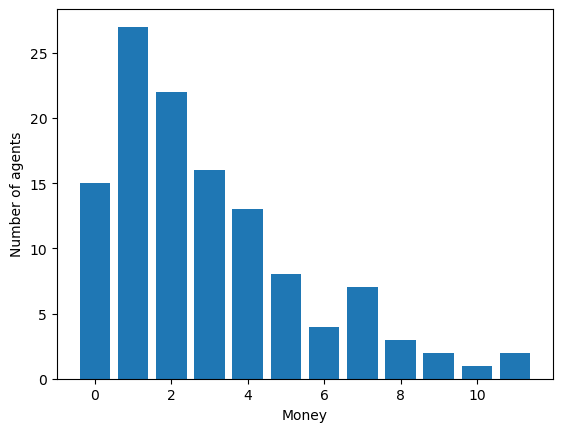

In [12]:
# Run model

model = MyModel(n_agents=120, initial_money_per_agent=3, max_steps=100)
model.run_model()  # executes steps until self.running becomes False (i.e. here after 100 steps)


# Plot task distribution
money_per_agent = [agent.money for agent in model.schedule.agents]
plt.hist(money_per_agent,
         bins=range(max(money_per_agent) + 1),
         align="left",
         rwidth=0.8)
plt.xlabel("Money")
plt.ylabel("Number of agents")
plt.show()

### Space and Agents

- How would you define the space where the Agents are placed? (take a look at `mesa.space.SingleGrid`)
- How would you define the neighbours of an Agent? 

In [13]:
from mesa.space import SingleGrid 

In [14]:
SingleGrid?

Init signature:
SingleGrid(
    width: 'int',
    height: 'int',
    torus: 'bool',
    property_layers: 'None | PropertyLayer | list[PropertyLayer]' = None,
)
Docstring:     
Rectangular grid where each cell contains exactly at most one agent.

Grid cells are indexed by [x, y], where [0, 0] is assumed to be the
bottom-left and [width-1, height-1] is the top-right. If a grid is
toroidal, the top and bottom, and left and right, edges wrap to each other.

This class provides a property `empties` that returns a set of coordinates
for all empty cells in the grid. It is automatically updated whenever
agents are added or removed from the grid. The `empties` property should be
used for efficient access to current empty cells rather than manually
iterating over the grid to check for emptiness.

Properties:
    width, height: The grid's width and height.
    torus: Boolean which determines whether to treat the grid as a torus.
    empties: Returns a set of (x, y) tuples for all empty cells. Thi